<a href="https://colab.research.google.com/github/vithushanms/micrograd-backpropagation/blob/main/%5BArtificial_Neural_Networks%5D_%5BExercise%5D_Backpropagation_with_PyTourch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import torch

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
#copy the final value function from previous notebook
class Value:
  def __init__(self, data, _children = (), _op='', label = ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda : None 

  #printing format
  def __repr__(self):
    return f"Value(data={self.data})"

  #addition function {Value Object + (Value Object or a number)}
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")
    
    def backward_fun():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad
    out._backward = backward_fun

    return out

  #substraction function {Value Object - (Value Object or a number)}
  def __sub__(self, other):
    return self + (-other)

  #multiplication function {Value Object * (Value Object or a number)}
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*") 
    
    def backward_fun():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = backward_fun

    return out

  #reverse add function {number * Value Object}
  def __radd__(self, other): 
    return self + other

  #reverse multiplication function {number * Value Object}
  def __rmul__(self, other):
    return self * other

  #division function {(Value object or number) / (Value object or number)}
  def __truediv__(self, other):
    return self * other**-1

  #power function {Value object ^ number}
  def __pow__(self, other):
    assert isinstance(other, (int, float)) #allow only the int and float as other for power values
    out = Value(self.data ** other, (self, ), f'**{other}')

    def backward_fun():
      self.grad += (other * (self.data ** (other -1))) * out.grad
    out._backward = backward_fun

    return out;

  #tanh fumction on the current Value object
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def backward_fun():
        out.grad += 1.0
        self.grad += (1 - t**2) * self.grad 
    out._backward = backward_fun

    return out

  #exponential on the current value object
  def exp(self):
    out = Value(math.exp(self.data), (self,), 'exp')

    def backward_fun():
      self.grad += out.data * out.grad
    out._backward = backward_fun

    return out

  #triggering Backpropagation from the last node
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [91]:
#copy graphiz code here
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [92]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Note: We are setting the requires_grad to true because by default gradients are not calculated for each tensor considering efficency reasons. Also we are casting them to double so it would be float64, otherwise it would be fload32 by default

In [93]:
torch.Tensor([2.0]).dtype

torch.float32

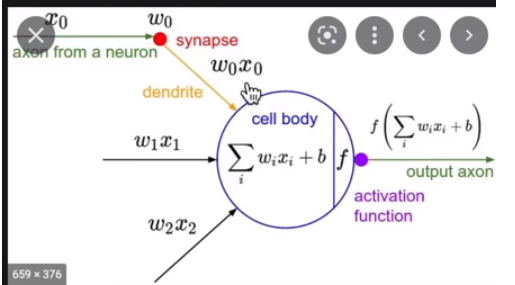

In [94]:
#Let's try to replicate Neurons 
import random

class Neuron:
  #nin  is number of inputs to the nurons
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
    return act.tanh()

x = [2.0,3.0]
n = Neuron(2)
n(x)

Value(data=0.6333214758804502)

In [95]:
#Let's add layers 
class Layer:
  #here nout is the number of neurons we want in a layer
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    out = [n(x) for n in self.neurons]
    return out[0] if len(out) == 1 else out

In [96]:
x = [2.0, 3.0]
n = Layer(2,4)
n(x)

[Value(data=0.9999164917702656),
 Value(data=-0.9948815275802698),
 Value(data=0.9416544290338233),
 Value(data=-0.5924661085489743)]

In [97]:
#Let's create multi layer preceptron
class MLP:
  #here the nouts is a list of numbers in each layers
  def __init__(self, nin, nouts):
    #appeand the number of inputs to the layers's first element
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)

    return x

In [98]:
x = [2.0, 3.0, 1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.6126367740104721)

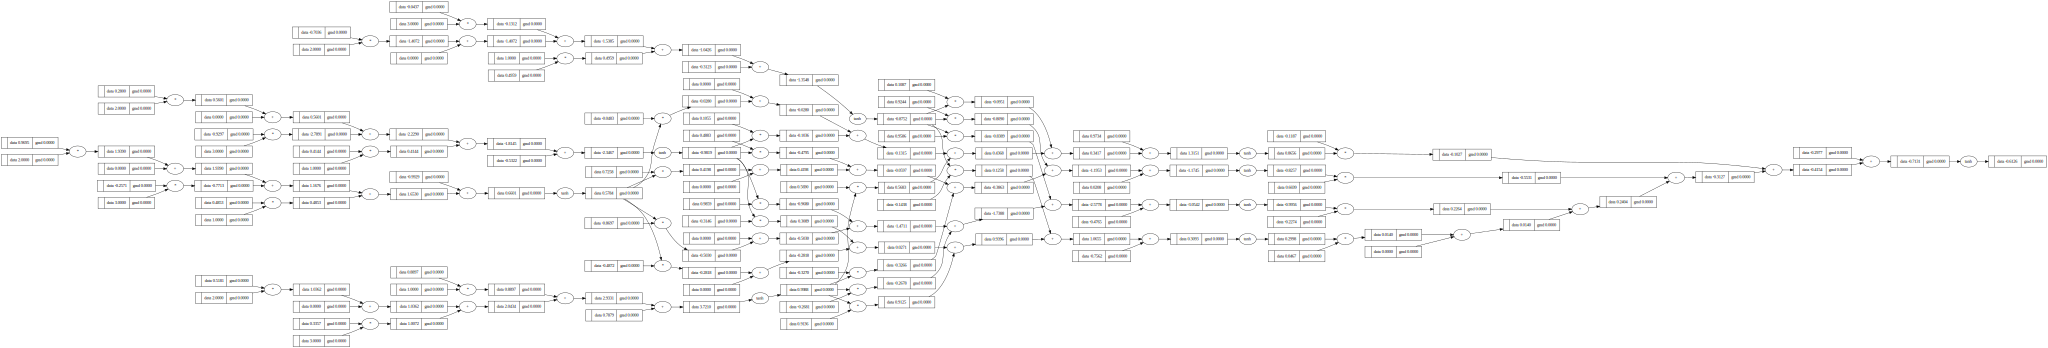

In [99]:
draw_dot(n(x))